In [73]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

In [60]:
device = "cpu"

In [ ]:
from transformers import SamModel, SamProcessor

sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# sam_model.vision_encoder is what we conceptually want

In [62]:
print(f"{sum(p.numel() for p in sam_model.parameters()):,d}")

93,735,472


In [ ]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
raw_image

In [28]:
device = "cpu"

In [87]:
import torch.nn.functional as F



In [89]:
image_b = torch.tensor(np.array(
            raw_image
            )).permute(2, 0, 1).unsqueeze(0)

image_resized = F.interpolate(
    image_b.float(),                # convert to float
    size=(1024, 1024),
    mode='bilinear',                # good for images
    align_corners=False
)

image_resized.shape

torch.Size([1, 3, 1024, 1024])

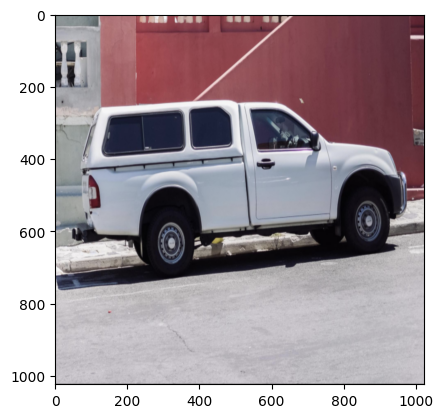

In [ ]:
img = image_resized.squeeze(0).permute(1, 2, 0).detach().cpu()
img = img.clamp(0, 255).byte().numpy()

plt.imshow(img)
plt.show()

In [ ]:
with torch.no_grad():
    local_features = sam_model.vision_encoder(image_resized)

local_features.last_hidden_state.shape

torch.Size([1, 256, 64, 64])

In [119]:
class conv_block(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = torch.nn.Conv2d(256, 512, stride = 2, kernel_size = 2)
        self.layer_2 = torch.nn.Conv2d(512, 1024, stride = 2, kernel_size = 2)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
Conv = conv_block()
Conv(local_features.last_hidden_state).shape

torch.Size([1, 1024, 16, 16])

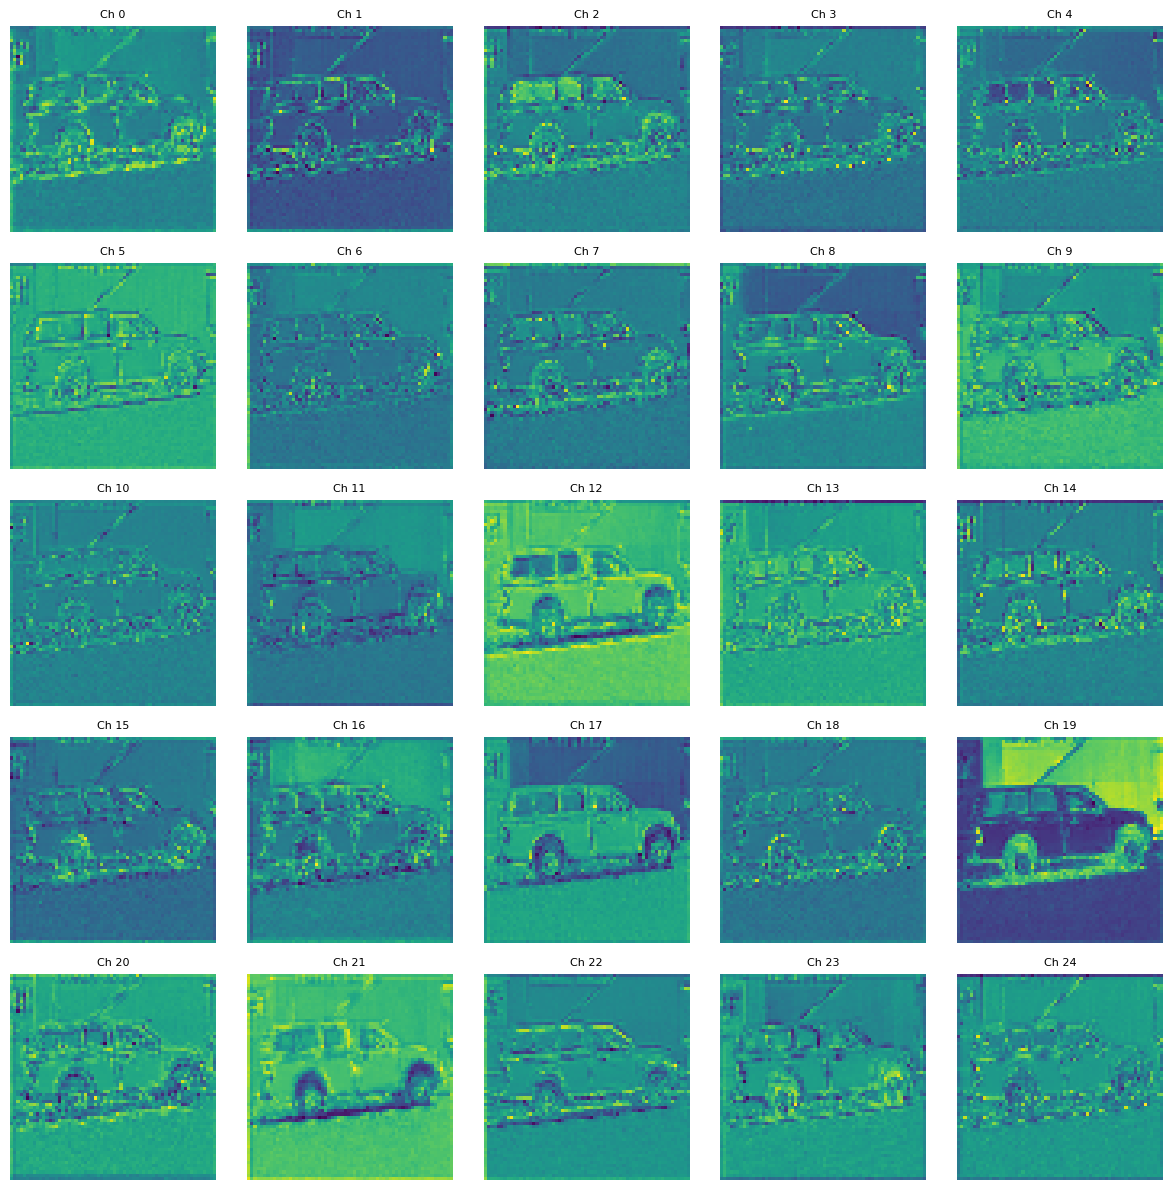

In [112]:
features = local_features.last_hidden_state.squeeze(0)  
# Now features.shape == [C, H, W]

num_channels = 25
rows, cols = 5, 5

plt.figure(figsize=(12, 12))

for i in range(num_channels):
    plt.subplot(rows, cols, i + 1)

    # Plot channel i
    plt.imshow(features[i].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.title(f"Ch {i}", fontsize=8)

plt.tight_layout()
plt.show()

In [58]:
for name, param in SAM.named_parameters():
    print(f"{name}: {param.shape}")

vision_encoder.pos_embed: torch.Size([1, 64, 64, 768])
vision_encoder.patch_embed.projection.weight: torch.Size([768, 3, 16, 16])
vision_encoder.patch_embed.projection.bias: torch.Size([768])
vision_encoder.layers.0.layer_norm1.weight: torch.Size([768])
vision_encoder.layers.0.layer_norm1.bias: torch.Size([768])
vision_encoder.layers.0.attn.rel_pos_h: torch.Size([27, 64])
vision_encoder.layers.0.attn.rel_pos_w: torch.Size([27, 64])
vision_encoder.layers.0.attn.qkv.weight: torch.Size([2304, 768])
vision_encoder.layers.0.attn.qkv.bias: torch.Size([2304])
vision_encoder.layers.0.attn.proj.weight: torch.Size([768, 768])
vision_encoder.layers.0.attn.proj.bias: torch.Size([768])
vision_encoder.layers.0.layer_norm2.weight: torch.Size([768])
vision_encoder.layers.0.layer_norm2.bias: torch.Size([768])
vision_encoder.layers.0.mlp.lin1.weight: torch.Size([3072, 768])
vision_encoder.layers.0.mlp.lin1.bias: torch.Size([3072])
vision_encoder.layers.0.mlp.lin2.weight: torch.Size([768, 3072])
vision_e

In [55]:
SAM.named_parameters()

<generator object Module.named_parameters at 0x16db09440>